The following projects aims to use PyTorch Neural Net to predict if a patient will have a Heart Failure or not based on given medical features.

# Main results Summary:

*Overall the algorithm performed well, since in this medical application it is better to be have false positives (false alarms of HeartFailure) than false negatives.<br>
In particular, the algorithm predicted just one patient to have the Heartfailure when in reality he was safe.*

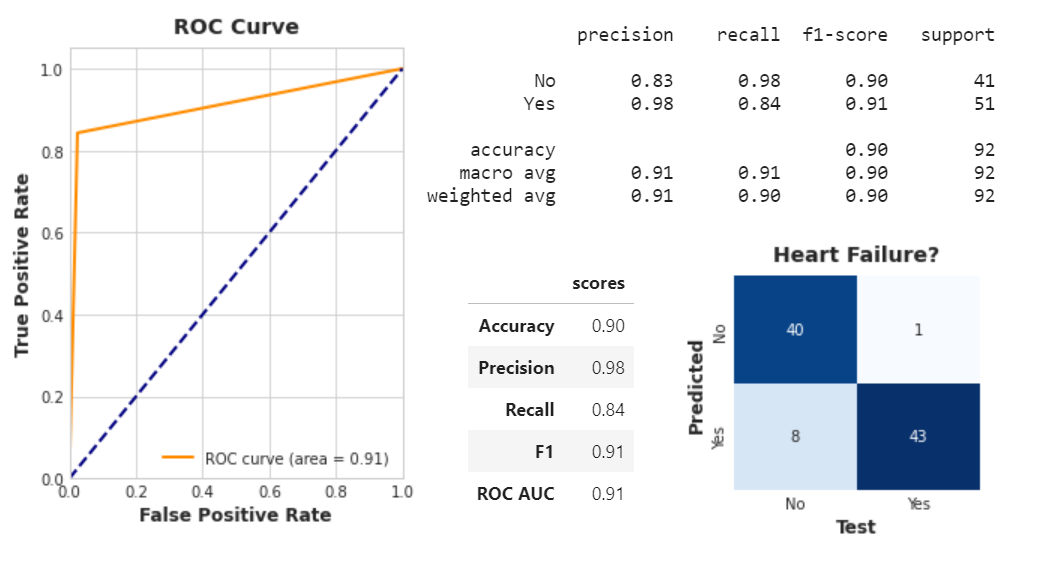

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-failure-prediction/heart.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer

import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


In [3]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv', skipinitialspace=True)

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Data Analysis

Are there null values?

In [6]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no null values.

Are there duplicate values?

In [7]:
df[df.duplicated()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


There are no duplicate values.

To simplify the following analysis, we will define a function to plot numerical features by plotly.

In [8]:
num_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']

In [9]:
def num_plot(df, col):
    fig = px.histogram(df, x=col, color="HeartDisease",
                       marginal="box")
    fig.update_layout(height=400, width=500, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()

In [10]:
for col in num_cols:
    num_plot(df,col)

There are outliers values for Colesterol and restingBP=0

In [11]:
df[df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


we will drop this value!

In [12]:
df = df[(df['RestingBP'] > 0)]

## What about 0 values of Cholesterol?

In [13]:
df[df['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


It seems like there are 171 patients with a cholesterol value=0.

In [14]:
num_plot(df,'Cholesterol')

In [15]:
print('Mean',df.Cholesterol.mean())
print('Median',df.Cholesterol.median())
print('Mode',df.Cholesterol.mode()[0])

Mean 199.0163576881134
Median 223.0
Mode 0


It looks like the most frequent value is cholesterol = 0.

In [16]:
df_no_chol = df[df['Cholesterol']==0]

In [17]:
for col in num_cols:
    num_plot(df_no_chol,col)

It looks like there are no common features among these patients with missing cholesterol value.<br>
Since imputing the mean or the median would affect too much the distribution, we will use a KNNImputer after encoding.

## What about the patients with cholesterol values different from zero?

In [18]:
df_chol = df[df['Cholesterol'] > 0]

In [19]:
num_plot(df[df['Cholesterol'] > 0],'Cholesterol')
print('Mean',df[df['Cholesterol'] > 0].Cholesterol.mean())
print('Median',df[df['Cholesterol'] > 0].Cholesterol.median())
print('Mode',df[df['Cholesterol'] > 0].Cholesterol.mode()[0])

Mean 244.6353887399464
Median 237.0
Mode 254


# Data Preprocessing

In [20]:
fig = px.histogram(df, x="HeartDisease", color="HeartDisease")
fig.update_layout(height=400, width=500, showlegend=True)
fig.update_traces(marker_line_width=1,marker_line_color="black")
fig.show()

# Encoding

Sex has only two classes, so we can encode it by 0 and 1.

In [21]:
df.Sex = df.Sex.replace({'M':0,'F':1})

In [22]:
df.ChestPainType.value_counts()

ASY    496
NAP    202
ATA    173
TA      46
Name: ChestPainType, dtype: int64

There are only 3 classes, we can encode it by OHE

In [23]:
df.ExerciseAngina.value_counts()

N    546
Y    371
Name: ExerciseAngina, dtype: int64

There are two classes, we will encode it by 0 and 1.

In [24]:
df.ExerciseAngina = df.ExerciseAngina.replace({'N':0,'Y':1})

In [25]:
df.ST_Slope.value_counts()

Flat    459
Up      395
Down     63
Name: ST_Slope, dtype: int64

There are only 3 classes, we can encode it by OHE

In [26]:
df.RestingECG.value_counts()

Normal    551
LVH       188
ST        178
Name: RestingECG, dtype: int64

There are only 3 classes, we can encode it by OHE

Then we also decide to shuffle the dataset to 

In [27]:
#df = shuffle(df)

In [28]:
encoded_df = pd.get_dummies(df, drop_first=True)

In [29]:
encoded_df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,0,140,289,0,172,0,0.0,0,1,0,0,1,0,0,1
1,49,1,160,180,0,156,0,1.0,1,0,1,0,1,0,1,0
2,37,0,130,283,0,98,0,0.0,0,1,0,0,0,1,0,1
3,48,1,138,214,0,108,1,1.5,1,0,0,0,1,0,1,0
4,54,0,150,195,0,122,0,0.0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,0,110,264,0,132,0,1.2,1,0,0,1,1,0,1,0
914,68,0,144,193,1,141,0,3.4,1,0,0,0,1,0,1,0
915,57,0,130,131,0,115,1,1.2,1,0,0,0,1,0,1,0
916,57,1,130,236,0,174,0,0.0,1,1,0,0,0,0,1,0


In [30]:
encoded_df.Cholesterol = encoded_df.Cholesterol.replace({0:np.nan})

In [31]:
encoded_df.Cholesterol.isna().sum()

171

## KNN Imputing

In [32]:
imputer = KNNImputer(n_neighbors=5)
encoded_df = pd.DataFrame(imputer.fit_transform(encoded_df),columns = encoded_df.columns)

In [33]:
num_plot(encoded_df[encoded_df['Cholesterol'] > 0],'Cholesterol')
print('Mean',encoded_df[encoded_df['Cholesterol'] > 0].Cholesterol.mean())
print('Median',encoded_df[encoded_df['Cholesterol'] > 0].Cholesterol.median())
print('Mode',encoded_df[encoded_df['Cholesterol'] > 0].Cholesterol.mode()[0])

Mean 244.952453653217
Median 239.2
Mode 230.0


We can see how the imputation by KNNImputer did not change the distribution too much, in contrast to a more easy mean or median imputation.

In [34]:
X = encoded_df.drop('HeartDisease', axis = 1).values

In [35]:
y = encoded_df['HeartDisease'].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42, stratify=y)

In [37]:
scaler = StandardScaler()
scaler.fit(X_train)      

StandardScaler()

In [38]:
X_train = scaler.transform(X_train)          
X_test = scaler.transform(X_test)  

# Pytorch NN

In [39]:
EPOCHS = 7
BATCH_SIZE = 60
LEARNING_RATE = 0.001

In [40]:
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data 
    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [41]:
train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

In [42]:
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [43]:
test_data = testData(torch.FloatTensor(X_test))

In [44]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(15, 45) 
        self.layer_out = nn.Linear(45, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(45)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [47]:
model = Net()
model.to(device)
print(model)

Net(
  (layer_1): Linear(in_features=15, out_features=45, bias=True)
  (layer_out): Linear(in_features=45, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [48]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)

In [49]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [50]:
for epoch in range(1, EPOCHS + 1):
    
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {epoch + 0:03}: || Loss: {epoch_loss/len(train_loader):.4f} || Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: || Loss: 0.6769 || Acc: 59.357
Epoch 002: || Loss: 0.5496 || Acc: 71.500
Epoch 003: || Loss: 0.4892 || Acc: 78.714
Epoch 004: || Loss: 0.4527 || Acc: 81.286
Epoch 005: || Loss: 0.4053 || Acc: 82.857
Epoch 006: || Loss: 0.4089 || Acc: 83.071
Epoch 007: || Loss: 0.3908 || Acc: 83.000


In [51]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

# Results Summary

In [52]:
confusion_matrix(y_test, y_pred_list)

array([[40,  1],
       [ 8, 43]])

In [53]:
print(classification_report(y_test, y_pred_list, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.83      0.98      0.90        41
         Yes       0.98      0.84      0.91        51

    accuracy                           0.90        92
   macro avg       0.91      0.91      0.90        92
weighted avg       0.91      0.90      0.90        92



In [54]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

In [55]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3,3))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False)
    plt.title('Heart Failure?')
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    ax.set_xlabel('Test')
    ax.set_ylabel('Predicted')

In [56]:
get_scores(y_test, y_pred_list)

,scores
Accuracy,0.90
Precision,0.98
Recall,0.84
F1,0.91
ROC AUC,0.91


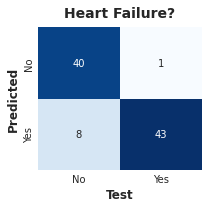

In [57]:
conf_matrix(y_test, y_pred_list)

As we can see from the confusion matrix, there is only 1 patient which actually had HeartFailure and was classified as safe by the algorithm.<br>
On the other hand, 8 patients which did not have heartfailure have been wrongly classified. Overall the algorithm performed well since it is better in this case to be have false positives (false allarm of HeartFailure) than a False negative, which would result in the patient death even though he was told to be safe.

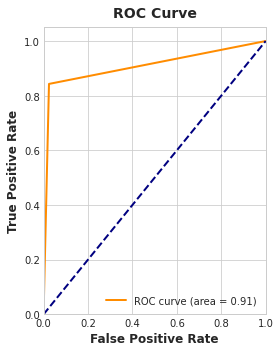

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_list)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

The performance of the Pytorch NN is very good in terms of scores, but could be improved by performing a deeper analysis of the dataset.

**Thanks for reading my notebook ! Let me know if you have questions or if you want me to check out your works !!**